%load_ext autoreload
%autoreload 2
https://blog.csdn.net/m0_46413065/article/details/129917287

In [5]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import MultiNormalizer,TorchNormalizer,GroupNormalizer

In [6]:
data_g2 = pd.read_csv("./Data/Kaohsiung/g2_scaled.csv",delimiter=';')
data = data_g2

features = ['date_time']
targets = ['EMove', 'NMove', 'HMove']

data['date_time'] = pd.to_datetime(data['date_time'])
data['date_time'] = data['date_time'].astype('int64') / (10 ** 11)
data['date_time'] = data['date_time'].astype('int64')


data = data[features+targets]
    
data['group_id'] = 0

C:\Users\lulu\AppData\Local\Temp\ipykernel_13292\4115666770.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['group_id'] = 0


In [7]:
print(data.columns)  # Check all the columns in the dataset


Index(['date_time', 'EMove', 'NMove', 'HMove', 'group_id'], dtype='object')


In [8]:
from sklearn.model_selection import train_test_split
max_prediction_length = 144
max_encoder_length =144
# Assuming `data` is already preprocessed and scaled.
train_data = data[:int(len(data)*0.8)]
val_data = data[int(len(data)*0.8):]

# Define your TimeSeriesDataSet for training
training = TimeSeriesDataSet(
    train_data,
    group_ids=["group_id"],
    target=targets,
    time_idx="date_time",
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    min_encoder_length=max_encoder_length // 2,  # Set based on your needs
    min_prediction_length=1,  # Same here
    time_varying_unknown_reals=targets,
    allow_missing_timesteps=True
)

# Define your TimeSeriesDataSet for validation
validation = TimeSeriesDataSet(
    val_data,
    group_ids=["group_id"],
    target=targets,
    time_idx="date_time",
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    min_encoder_length=max_encoder_length // 2,  # Adjust based on validation needs
    min_prediction_length=1,
    time_varying_unknown_reals=targets,
    allow_missing_timesteps=True
)

batch_size = 32

train_dataloader = training.to_dataloader(train=True,batch_size=batch_size,shuffle=False,num_workers=4)
val_dataloader = validation.to_dataloader(train=False,batch_size=batch_size,shuffle=False,num_workers=4)


In [9]:
print(f"Total dataset size: {len(data)}")
print(f"Training size: {len(training)}")
print(f"Validation size: {len(validation)}")
# for i, sample in enumerate(validation):
#     print(i, sample)
print(data["group_id"].value_counts())  # See if some groups are too small



Total dataset size: 30736
Training size: 28710
Validation size: 7305
group_id
0    30736
Name: count, dtype: int64


In [10]:
#有問題，所以先跳過
# from pytorch_forecasting import Baseline

# # Retrieve actuals and ensure proper stacking
# # actuals = torch.cat([
# #     (y if isinstance(y, torch.Tensor) else y[0])  # Handling if `y` is a list or tensor
# #     for x, (y, weight) in iter(val_dataloader)
# # ], dim=0)
# from torch.nn.utils.rnn import pad_sequence

# # Make sure that y is padded to the same length in each batch
# y_padded = torch.stack([pad_sequence([torch.tensor(yi_i) for yi_i in yi], batch_first=True) for yi in y], dim=2)

# # Concatenate actuals across batches
# actuals = torch.cat([y_padded for x, (y, weight) in iter(val_dataloader)], dim=0)
# actuals=actuals.transpose(2, 1)


# # Get baseline predictions
# baseline_predictions = Baseline().predict(val_dataloader)

# # Ensure `baseline_predictions` is a tensor
# if isinstance(baseline_predictions, list):
#     baseline_predictions = torch.stack(baseline_predictions, dim=1)  # Stack if it's a list

# # Ensure baseline_predictions is on the same device as actuals
# baseline_predictions = baseline_predictions.to(actuals.device)

# # Print shapes to debug
# print(f"Shape of actuals: {actuals.shape}")
# print(f"Shape of baseline_predictions: {baseline_predictions.shape}")

# # Calculate MAE for each target (across all time steps for each target)
# result = (actuals - baseline_predictions).abs().mean(dim=[0, 2])  # Compute MAE for each target

# # Print MAE results
# print("MAE for each target:", result.tolist())


In [11]:
print(f"Number of batches in val_dataloader: {len(val_dataloader)}")
print(f"Length of validation dataset: {len(validation)}")
# Extract the first batch of the validation dataloader


# Initialize a list to hold actual targets (y values)
actuals = []

# Loop through the val_dataloader and collect the targets (y values)
for batch_idx, batch in enumerate(val_dataloader):
    print(f"Batch {batch_idx}: {batch}")

    # Assuming the batch is a tuple (x, y), where x is the inputs and y is the targets
    if isinstance(batch, tuple):
        x, y = batch  # x is inputs, y is targets
    else:
        y = batch  # If batch is a dictionary, extract y (targets)
    
    # y should be the targets that we need for comparison with predictions
    for target in y:
        # Ensure the target is a tensor before appending
        if isinstance(target, torch.Tensor):
            actuals.append(target)

# After the loop, `actuals` will be a list of tensors (targets)

# Step 1: Concatenate all the tensors in actuals
actuals = torch.cat(actuals, dim=0)  # Concatenate the tensors along the first dimension

# Step 2: Reshape actuals to match the shape of predictions (3, 7305, 144)
# Assuming actuals needs to be reshaped into (3, 7305, 144) to match predictions
actuals = actuals.view(3, 7305, 144)

# Now, let's print the shapes to verify
print(f"Actuals shape after reshaping: {actuals.shape}")


Number of batches in val_dataloader: 229
Length of validation dataset: 7305
Batch 0: ({'encoder_cat': tensor([], size=(32, 139, 0), dtype=torch.int64), 'encoder_cont': tensor([[[ 0.9306, -2.7280, -1.7190, -1.4589],
         [ 0.9306, -2.7280, -1.7190, -1.4589],
         [ 0.9306, -2.7280, -1.7190, -1.4589],
         ...,
         [ 0.9306,  1.1103,  1.4909,  0.8484],
         [ 0.9306,  1.1103,  1.4909,  0.8484],
         [ 0.9306,  2.4217,  1.6501,  0.8381]],

        [[ 0.9306, -1.4059, -2.0001, -1.2750],
         [ 0.9306, -1.4059, -2.0001, -1.2750],
         [ 0.9306, -1.4059, -2.0001, -1.2750],
         ...,
         [ 0.9306,  2.3456,  1.5255,  0.7652],
         [ 0.9306,  2.3456,  1.5255,  0.7652],
         [ 0.9306,  2.2773,  1.6601,  0.9254]],

        [[ 0.9306, -0.7389, -1.0412, -1.7499],
         [ 0.9306, -0.7389, -1.0412, -1.7499],
         [ 0.9306, -0.7389, -1.0412, -1.7499],
         ...,
         [ 0.9306,  2.0021,  1.5572,  0.8511],
         [ 0.9306,  2.0021,  1.557

RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [12]:
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TemporalFusionTransformer, QuantileLoss, MultiLoss

#5次loss改善小於1e-4時，停止訓練
#目的是避免overfitting
early_stop_callback = EarlyStopping(monitor="val_loss",min_delta=1e-4,patience=5,verbose=True,mode="min")
#記錄學習率的變化
lr_logger = LearningRateMonitor()
#將訓練數據存入Lightning_logs資料夾
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=15,  #最多訓練幾次
    accelerator = 'gpu',    #用gpu訓練(加速)
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,  #限制梯度最大值，避免梯度爆炸
    accumulate_grad_batches=4,  #每4個batch累積梯度後，進行權重更新
    callbacks=[lr_logger,early_stop_callback],
    logger=logger
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.005,
    hidden_size=128,
    attention_head_size=4,
    dropout=0.2,    #隨機丟棄30%神經元，避免overfitting
    hidden_continuous_size=32,
    optimizer="ranger",   #優化器
    output_size=[7,7,7], #len(targets),
    loss=MultiLoss([QuantileLoss(),QuantileLoss(),QuantileLoss()]),
    log_interval=10,    #每10 batch紀錄一次log
    reduce_on_plateau_patience=2    #兩次沒有改善時調整學習率
)

import torch.nn.init as init
def init_tft_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)  # Xavier 初始化
        if m.bias is not None:
            init.zeros_(m.bias)

# 將初始化套用到 TFT 模型
tft.apply(init_tft_weights)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

ModuleNotFoundError: Neither `tensorboard` nor `tensorboardX` is available. Try `pip install`ing either.
Requirement 'tensorboardX' not met. HINT: Try running `pip install -U 'tensorboardX'`
Requirement 'tensorboard' not met. HINT: Try running `pip install -U 'tensorboard'`

In [46]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs/lightning_logs/version_36/checkpoints/epoch=5-step=1236.ckpt


/home/undergrad/miniconda3/envs/114/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/undergrad/miniconda3/envs/114/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [47]:
for x, (y, weight) in iter(val_dataloader):
    print(f"Type of y: {type(y)}")
    print(f"Example of y: {y}")
    break  # Just checking one batch

Type of y: <class 'list'>
Example of y: [tensor([[-64.0000, -62.8000, -62.8000, -62.8000, -62.8000, -62.8000, -62.8000,
         -62.0000, -62.0000, -62.0000, -62.0000, -62.0000, -62.0000, -61.5000]]), tensor([[-545.5000, -545.3000, -545.3000, -545.3000, -545.3000, -545.3000,
         -545.3000, -544.6000, -544.6000, -544.6000, -544.6000, -544.6000,
         -544.6000, -543.2000]]), tensor([[67.6000, 71.5000, 71.5000, 71.5000, 71.5000, 71.5000, 71.5000, 72.0000,
         72.0000, 72.0000, 72.0000, 72.0000, 72.0000, 72.6000]])]


In [48]:
# # Assuming val_dataloader yields batches in the form of (inputs, targets)
# # We will extract the actuals (targets) from one batch of the validation dataloader

# # Get one batch from the val_dataloader (assuming it's not empty)
# for batch in val_dataloader:
#     inputs, actuals = batch
#     break  # Extract only the first batch

# # Now actuals should have the target values (shape: [batch_size, num_targets, num_time_steps])
# print(f"Actuals shape: {actuals.shape}")

# # Ensure the shape of actuals matches the predictions (3, 7305, 144)
# # You may need to reshape or permute dimensions depending on how the targets are structured

# # Reshape or permute the actuals to match predictions' shape (3, 7305, 144)
# predictions = best_tft.predict(val_dataloader)
# predictions = torch.stack(predictions)  # This assumes each element in predictions is a tensor of shape (num_samples, 1)

# actuals = actuals.permute(2, 0, 1)  # Example permutation to match (3, 7305, 144) format

# # Verify the shape
# print(f"Actuals shape after adjustment: {actuals.shape}")
# print(f"Predictions shape: {predictions.shape}")

# # Ensure that the number of groups (dim 0) is the same
# if actuals.shape[0] != predictions.shape[0]:
#     raise ValueError(f"Mismatch in the number of prediction groups: {actuals.shape[0]} != {predictions.shape[0]}")

# # Now check that the number of time steps (dim 1) and targets (dim 2) match
# if actuals.shape[1:] != predictions.shape[1:]:
#     raise ValueError(f"Mismatch in the shape of time steps and targets: {actuals.shape[1:]} != {predictions.shape[1:]}")

#---------

predictions = best_tft.predict(val_dataloader)
# Debugging: Check the shape of each element in the predictions list
for i, pred in enumerate(predictions):
    print(f"Prediction {i} shape: {pred.shape}")

# After stacking, check the final shape of predictions
predictions = torch.stack(predictions)

from sklearn.metrics import mean_absolute_error, mean_squared_error 

#mae_T = mean_absolute_error(actuals, predictions)
#rmse_T = np.sqrt(mean_squared_error(actuals, predictions))

#print(mae_T,'\n',rmse_T)

# 对于每个目标，计算 MAE 和 RMSE
for target_idx in range(3):  # 假设 actuals 和 predictions 的形状是 (num_samples, num_targets)
    actual_target = actuals[target_idx , :].cpu().numpy()
    predicted_target = predictions[target_idx,:].cpu().numpy()  # Ensure predictions have the same shape
    # print(actual_target,'\n',predicted_target)

    mae = mean_absolute_error(actual_target, predicted_target)
    rmse = np.sqrt(mean_squared_error(actual_target, predicted_target))

    print(f"Target {target_idx + 1} MAE: {mae:.4f}")
    print(f"Target {target_idx + 1} RMSE: {rmse:.4f}")

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


actuals shape: torch.Size([3, 14])
predictions shape: torch.Size([3, 14])
[-64.  -62.8 -62.8 -62.8 -62.8 -62.8 -62.8 -62.  -62.  -62.  -62.  -62.
 -62.  -61.5] 
 [-22.836641  -20.470846  -17.36033   -14.206268  -11.542515   -9.589161
  -8.275901   -7.435671   -6.9096856  -6.5814095  -6.374381   -6.2406387
  -6.1509705  -6.087868 ]
Target 1 MAE: 51.7313
Target 1 RMSE: 51.9754
[-545.5 -545.3 -545.3 -545.3 -545.3 -545.3 -545.3 -544.6 -544.6 -544.6
 -544.6 -544.6 -544.6 -543.2] 
 [-37.479115 -42.85597  -46.4231   -47.54344  -46.427418 -44.54745
 -42.83591  -41.522137 -40.570553 -39.8938   -39.40642  -39.04718
 -38.774223 -38.559345]
Target 2 MAE: 503.0152
Target 2 RMSE: 503.0237
[67.6 71.5 71.5 71.5 71.5 71.5 71.5 72.  72.  72.  72.  72.  72.  72.6] 
 [ -9.905953 -13.774506 -17.251822 -19.45363  -20.495153 -20.797705
 -20.769539 -20.62554  -20.465115 -20.326675 -20.218143 -20.137249
 -20.078775 -20.037334]
Target 3 MAE: 90.3955
Target 3 RMSE: 90.4872


In [49]:
actuals_E = actuals[:, 0].cpu().numpy()
predicted_E = predictions[:,0].cpu().numpy()

print(actuals_E ,'\n' , predicted_E)
print(predictions,"\n")
print(actuals)

[ -64.  -545.5   67.6] 
 [-22.836641 -37.479115  -9.905953]
tensor([[-22.8366, -20.4708, -17.3603, -14.2063, -11.5425,  -9.5892,  -8.2759,
          -7.4357,  -6.9097,  -6.5814,  -6.3744,  -6.2406,  -6.1510,  -6.0879],
        [-37.4791, -42.8560, -46.4231, -47.5434, -46.4274, -44.5475, -42.8359,
         -41.5221, -40.5706, -39.8938, -39.4064, -39.0472, -38.7742, -38.5593],
        [ -9.9060, -13.7745, -17.2518, -19.4536, -20.4952, -20.7977, -20.7695,
         -20.6255, -20.4651, -20.3267, -20.2181, -20.1372, -20.0788, -20.0373]],
       device='cuda:0') 

tensor([[ -64.0000,  -62.8000,  -62.8000,  -62.8000,  -62.8000,  -62.8000,
          -62.8000,  -62.0000,  -62.0000,  -62.0000,  -62.0000,  -62.0000,
          -62.0000,  -61.5000],
        [-545.5000, -545.3000, -545.3000, -545.3000, -545.3000, -545.3000,
         -545.3000, -544.6000, -544.6000, -544.6000, -544.6000, -544.6000,
         -544.6000, -543.2000],
        [  67.6000,   71.5000,   71.5000,   71.5000,   71.5000,   71.500

[-64.  -62.8 -62.8 -62.8 -62.8 -62.8 -62.8 -62.  -62.  -62.  -62.  -62.
 -62.  -61.5] 
 [-22.836641  -20.470846  -17.36033   -14.206268  -11.542515   -9.589161
  -8.275901   -7.435671   -6.9096856  -6.5814095  -6.374381   -6.2406387
  -6.1509705  -6.087868 ]


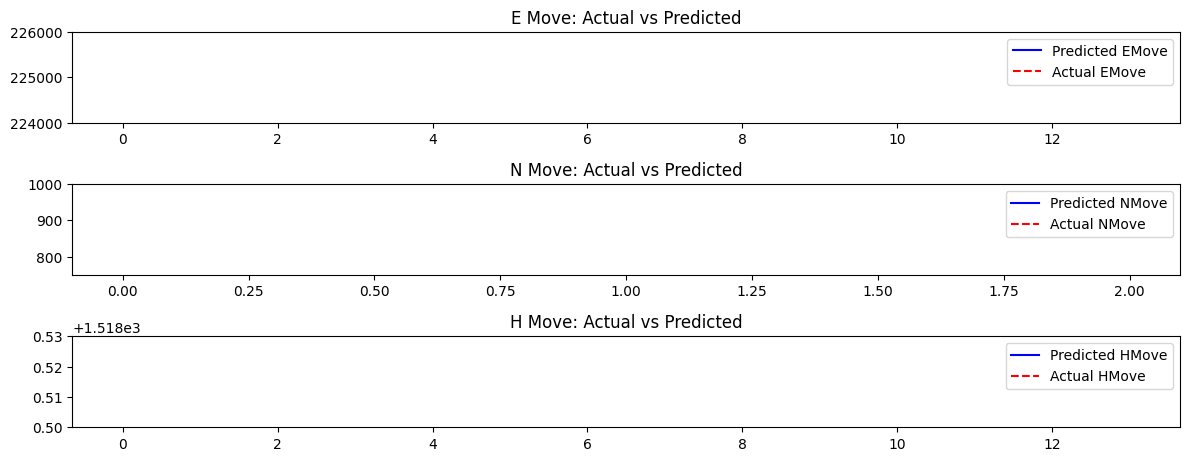

In [50]:
import matplotlib.pyplot as plt
print(actuals)
# Find global min and max for y-axis across all movement components
# y_min = 750  # You can adjust this to the actual min of your data
# y_max = 1000  # You can adjust this to the actual max of your data

y_min = min(
    min(np.min(actuals[0,:].cpu().numpy(), axis=0), np.min(predictions[0,:].cpu().numpy(), axis=0)),
    min(np.min(actuals[1,:].cpu().numpy(), axis=0), np.min(predictions[1,:].cpu().numpy(), axis=0)),
    min(np.min(actuals[2,:].cpu().numpy(), axis=0), np.min(predictions[2,:].cpu().numpy(), axis=0))
)  # Min value

y_max = max(
    max(np.max(actuals[0,:].cpu().numpy(), axis=0), np.max(predictions[0,:].cpu().numpy(), axis=0)),
    max(np.max(actuals[1,:].cpu().numpy(), axis=0), np.max(predictions[1,:].cpu().numpy(), axis=0)),
    max(np.max(actuals[2,:].cpu().numpy(), axis=0), np.max(predictions[2,:].cpu().numpy(), axis=0))
)  # Max value


# Plot predictions vs actual values for each movement component
plt.figure(figsize=(12, 6))

# For EMove (target 0)
actuals_E = actuals[0,:].cpu().numpy()
predicted_E = predictions[0,:].cpu().numpy()
print(actuals_E,'\n',predicted_E)
plt.subplot(4, 1, 1)
plt.plot(predicted_E, label="Predicted EMove", color='blue')
plt.plot(actuals_E, label="Actual EMove", color='red', linestyle='dashed')
plt.title("E Move: Actual vs Predicted")
plt.ylim(y_min,y_max)  # Set same y-axis range
plt.legend()

# For NMove (target 1)
actuals_N = actuals[1,:].cpu().numpy()
predicted_N = predictions[1,:].cpu().numpy()
plt.subplot(4, 1, 2)
plt.plot(predicted_N, label="Predicted NMove", color='blue')
plt.plot(actuals_N, label="Actual NMove", color='red', linestyle='dashed')
plt.title("N Move: Actual vs Predicted")
plt.ylim(y_min, y_max)  # Set same y-axis range
plt.legend()

# For HMove (target 2)
actuals_H = actuals[2,:].cpu().numpy()
predicted_H = predictions[2,:].cpu().numpy()
plt.subplot(4, 1, 3)
plt.plot(predicted_H, label="Predicted HMove", color='blue')
plt.plot(actuals_H, label="Actual HMove", color='red', linestyle='dashed')
plt.title("H Move: Actual vs Predicted")
plt.ylim(y_min,y_max)  # Set same y-axis range
plt.legend()

plt.tight_layout()
plt.show()


/tmp/ipykernel_669476/3086205001.py:37: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


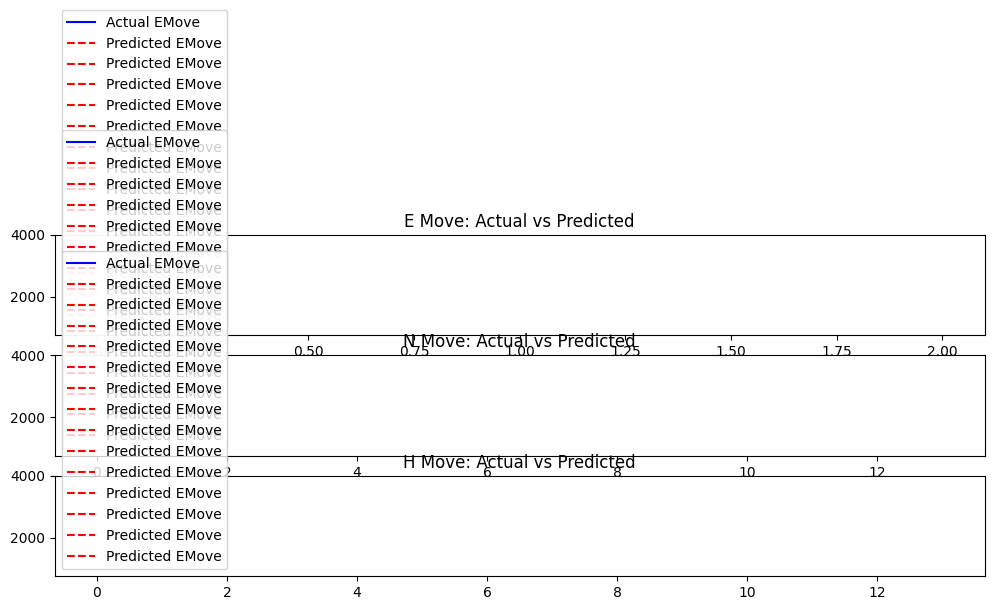

In [51]:
import matplotlib.pyplot as plt

# Find global min and max for y-axis across all movement components
y_min = 750#min(y_test_trues.min(), y_test_preds.min(), total_move_test_true.min(), total_move_test_pred.min())
y_max = 4000#max(y_test_trues.max(), y_test_preds.max(), total_move_test_true.max(), total_move_test_pred.max())

# Plot predictions vs actual values for  each movement component
plt.figure(figsize=(12, 6))

actuals[0, 0].cpu().numpy()
predicted_target = predictions[:,0].cpu().numpy()
plt.subplot(4, 1, 1)
plt.plot(predicted_target, label="Actual EMove", color='blue')
plt.plot(actuals, label="Predicted EMove", color='red', linestyle='dashed')
plt.title("E Move: Actual vs Predicted")
plt.ylim(y_min, y_max)  # Set same y-axis range
plt.legend()

actuals = torch.cat([y[1] for x,(y,weight) in iter(val_dataloader)])
predicted_target = predictions[1].cpu()
plt.subplot(4, 1, 2)
plt.plot(predicted_target, label="Actual EMove", color='blue')
plt.plot(actuals, label="Predicted EMove", color='red', linestyle='dashed')
plt.title("N Move: Actual vs Predicted")
plt.ylim(y_min, y_max)  # Set same y-axis range
plt.legend()

actuals = torch.cat([y[2] for x,(y,weight) in iter(val_dataloader)])
predicted_target = predictions[2].cpu()
plt.subplot(4, 1, 3)
plt.plot(predicted_target, label="Actual EMove", color='blue')
plt.plot(actuals, label="Predicted EMove", color='red', linestyle='dashed')
plt.title("H Move: Actual vs Predicted")
plt.ylim(y_min, y_max)  # Set same y-axis range
plt.legend()

plt.tight_layout()
plt.show()